<a href="https://colab.research.google.com/github/dlskawns/RecSys_and_Retrieval_Study/blob/main/LG_Uplus_competition_Proto_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo tar -zxvf "/content/drive/MyDrive/data.tar.gz"

In [ ]:
# !mkdir data
# !mkdir code

In [ ]:
!sudo tar -zxvf "/content/drive/MyDrive/data.tar.gz" -C "/content/data"
!sudo tar -zxvf "/content/drive/MyDrive/code.tar.gz" -C "/content/code"

In [ ]:
!pip install -r "/content/drive/MyDrive/code/requirements.txt"

In [ ]:
!pip list

In [ ]:
!python -m ipykernel install --user --name recsys --display-name recsys

Installed kernelspec recsys in /root/.local/share/jupyter/kernels/recsys


In [ ]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import plotnine
from plotnine import *

In [ ]:
# 하이퍼파라미터 
class cfg: 
    gpu_idx = 0
    device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
    top_k = 25
    seed = 42
    neg_ratio = 100
    test_size = 0.2

In [ ]:
# 시드 고정 
def seed_everything(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
seed_everything(cfg.seed)

In [ ]:
# 경로 설정
data_path = '../data'
saved_path = './saved'
output_path = './submission'

### 데이터 불러오기
- history_data : 시청 시작 데이터
- profile_data : 프로필 정보 
- meta_data : 콘텐츠 일반 메타 정보

In [ ]:
# 데이터 불러오기 
history_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/history_data.csv'), encoding='utf-8')
profile_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/profile_data.csv'), encoding='utf-8')
meta_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/meta_data.csv'), encoding='utf-8')
buy_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/buy_data.csv'), encoding='utf-8')
watch_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/watch_e_data.csv'), encoding='utf-8')
search_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/search_data.csv'), encoding='utf-8')
metap_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/meta_data_plus.csv'), encoding='utf-8')

In [ ]:
history_df.head(3)

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
0,3,20220301115653,20220301115719,MKID003,15,NaN,Y,N
1,3,20220301115653,20220301115809,MKID003,16,NaN,Y,N
2,3,20220301115653,20220301115958,MKID003,17,NaN,Y,N


In [ ]:
# object features에 대한 개요 파악
history_df.describe( include= 'object')

,act_target_dtl,continuous_play,short_trailer
count,1005651,1005651,1005651
unique,1,2,2
top,MKID003,Y,N
freq,1005651,889517,945784


In [ ]:
# 결측치 파악
history_df.isnull().sum()

profile_id              0
ss_id                   0
log_time                0
act_target_dtl          0
album_id                0
payment            932165
continuous_play         0
short_trailer           0
dtype: int64

궁금한점:
* payment feature는 NaN값이 있고 아닌것이 있는데, 이 두개의 구분은 어떻게 되는 것인가?
* 연속 플레이의 분포는 어떻게 이뤄져있을까? - 만약 연속 플레이의 빈도 자체가 월등히 높다면, 그것이 본 것으로 간주되기 때문에 연속 플레이가 시청 예측에 연관성이 있을 수 있다.
* 예고편의 분포는 어떻게 이뤄져있을까? - 이 역시도 연속 플레이와 동일하게 간주할 수 있음
* 필요한 feature는 아래와 같음
  * profile_id: 유저 식별
  * log_time: 시청 시각
  * albm_id: 아이템 식별
  * continuous_play: 연속 플레이
  * short_trailer: 예고편

In [ ]:
# 연속플레이 / 예고편에 대한 요소 분포 파악
print(history_df.continuous_play.value_counts())
print(history_df.short_trailer.value_counts())

Y    889517
N    116134
Name: continuous_play, dtype: int64
N    945784
Y     59867
Name: short_trailer, dtype: int64


연속 플레이는 거의 90%에 해당하는 만큼 관련성이 있는 것으로 보임. 다만 예고편의 경우는 컨텐츠 자체의 예고편 여부로 판단할 수 있으므로 제외.

In [ ]:
from datetime import datetime
h_df = history_df[['profile_id','log_time','album_id','continuous_play']]
h_df['continuous_play'] = h_df['continuous_play'].map(lambda x: 1 if x == 'Y' else 0)
h_df['y'] = h_df.log_time.map(lambda x: str(x)[:4])
h_df['m'] = h_df.log_time.map(lambda x: str(x)[4:6])
h_df['d'] = h_df.log_time.map(lambda x: str(x)[6:8])
h_df['time'] = h_df.log_time.map(lambda x: str(x)[-6:-4])
h_df['dow'] = h_df.log_time.map(lambda x: datetime.strptime(str(x)[:-6], '%Y%m%d').weekday())
# 기존 로그타임과 연도는 삭제처리 후 분석 진행
h_df = h_df.drop(columns = ['log_time','y'])

In [ ]:
h_df.head(3)

,profile_id,album_id,continuous_play,m,d,time,dow
0,3,15,1,03,01,11,1
1,3,16,1,03,01,11,1
2,3,17,1,03,01,11,1


In [ ]:
print(h_df.y.value_counts())
print(h_df.m.value_counts())
print(h_df.d.value_counts())
# print(h_df.time.value_counts())

In [ ]:
print(metap_df.shape)
metap_df.head(3)

(767948, 4)


,album_id,keyword_type,keyword_name,keyword_value
0,749,05010101,시리즈,0
1,749,05010302,EBS,0
2,749,05010401,3세,0


In [ ]:
print(f'meta plus정보의 shape: {metap_df.shape}')
print(f'keyword_type의 unique개수: {metap_df.keyword_type.nunique()}개')
print(f'keyword_name의 unique개수: {metap_df.keyword_name.nunique()}개')
print(f'keyword_value의 unique개수: {metap_df.keyword_value.nunique()}개')

meta plus정보의 shape: (767948, 4)
keyword_type의 unique개수: 1101개
keyword_name의 unique개수: 1062개
keyword_value의 unique개수: 6개


In [ ]:
meta_df.head(3)

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
0,749,어둠이 무서워요,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
1,750,우리는 친구,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
2,2131,타요의 첫 운행,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN


아이템 메타 정보에서 필요한 것 선택 후 메타 확장정보 추가
* 메타정보
  * album_id: 아이템 식별
  * genre_mid: 중분류
  * country: 국가
  * run_time: 총 시간
* 메타 확장정보 (추후에 추가여부 결정)
  * keyword_type: 태그 타입
  * keyword_value: 태그 일치 등급

In [ ]:
# meta = pd.merge(meta_df[['album_id','genre_mid','run_time']], metap_df, "left", on = 'album_id' )
meta = meta_df[['album_id','genre_mid','run_time']].drop_duplicates()
meta.shape

(39875, 3)

In [ ]:
profile_df.head(3)

,profile_id,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,F,5,P02,P04,P07,K01,K03,K04
1,5,M,5,P07,P08,P06,K05,K08,K09
2,7,F,9,P05,P03,NaN,K06,K04,NaN


프로파일에서 가져올 데이터
* profile_id: 유저 식별
* sex: 성별 식별
* age: 연령 식별
* pr_interest_keyword_cd_1
* ch_interest_keyword_cd_1

In [ ]:
print(history_df.shape)
print(h_df.shape)
print(meta_df.shape)
print(metap_df.shape)
print(meta.shape)
print(profile_df.shape)

(1005651, 8)
(1005651, 7)
(42602, 16)
(767948, 4)
(39875, 3)
(8311, 9)


In [ ]:
# history + item meta + user meta를 한 데이터프레임으로 활용

df = pd.merge(h_df, profile_df[['profile_id','sex','age','pr_interest_keyword_cd_1','ch_interest_keyword_cd_1']], 'left', on = 'profile_id')
df = pd.merge(df, meta, 'left', on = 'album_id')
# df.head(3)
df.shape

(1005651, 13)

### 연령대 관련 EDA

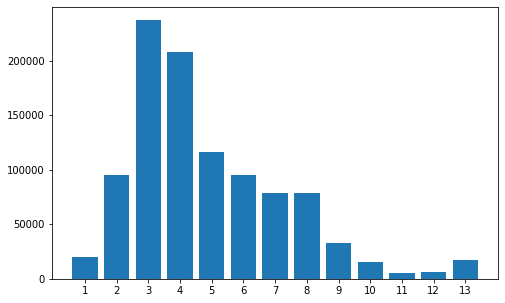

In [ ]:
import seaborn as sns
# 연령별 시청 빈도 분포
plt.bar(df['age'].value_counts().index, df['age'].value_counts().values)
plt.rcParams['figure.figsize'] = (8,5)
plt.xticks(df['age'].value_counts().index)
plt.show()

In [ ]:
view_cnts = df.groupby('profile_id')['album_id'].count()
df['views'] = df['profile_id'].map(lambda x: view_cnts[x])

In [ ]:
# 연령대 별 평균 view를 파악
df[['profile_id','age','views']].drop_duplicates().groupby('age')['views'].mean()

age
1      90.559091
2     198.930962
3     218.083640
4     168.275667
5      98.873720
6      88.117100
7      78.224775
8      69.086463
9      69.531381
10     72.552885
11     51.096154
12    130.311111
13    298.322034
Name: views, dtype: float64

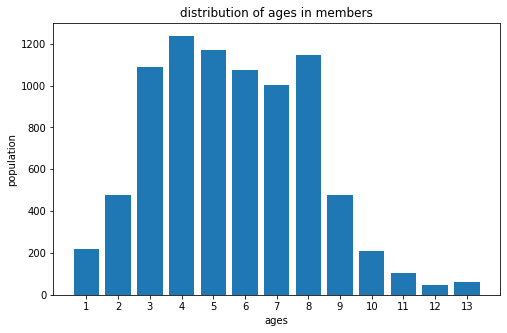

In [ ]:
# 연령별 회원 수
plt.bar(df[['profile_id', 'age']].drop_duplicates().groupby('age').count().index,height = df[['profile_id', 'age']].drop_duplicates().groupby('age').count()['profile_id'].values)
plt.xticks(df[['profile_id', 'age']].drop_duplicates().groupby('age').count().index)
plt.xlabel('ages')
plt.ylabel('population')
plt.title('distribution of ages in members')
plt.show()



In [ ]:
list(df[df['age']==i]['genre_mid'].value_counts(True)[:4].index)

['TV만화', '애니', '노래율동', '책']

In [ ]:
# 가설: 연령 별 주 장르에 차이가 있다
for i in range(1,14):
  print(i, ':',df[df['age']==i]['genre_mid'].value_counts(True)[:4])

1 : 노래율동    0.426894
TV만화    0.232646
책       0.167846
놀이교실    0.066054
Name: genre_mid, dtype: float64
2 : 노래율동    0.819401
TV만화    0.101673
책       0.037817
놀이교실    0.014933
Name: genre_mid, dtype: float64
3 : 노래율동    0.644897
TV만화    0.208092
책       0.070366
놀이교실    0.030218
Name: genre_mid, dtype: float64
4 : 노래율동    0.425981
TV만화    0.259626
책       0.119098
놀이교실    0.082808
Name: genre_mid, dtype: float64
5 : 노래율동    0.292587
TV만화    0.243234
책       0.207154
놀이교실    0.133612
Name: genre_mid, dtype: float64
6 : 책       0.298975
TV만화    0.247959
노래율동    0.244405
놀이교실    0.096631
Name: genre_mid, dtype: float64
7 : 책       0.373268
TV만화    0.226990
노래율동    0.161692
놀이교실    0.107084
Name: genre_mid, dtype: float64
8 : 책       0.301287
TV만화    0.247687
노래율동    0.194630
놀이교실    0.113218
Name: genre_mid, dtype: float64
9 : 책       0.291311
TV만화    0.289686
노래율동    0.135125
놀이교실    0.098718
Name: genre_mid, dtype: float64
10 : TV만화    0.414154
책       0.216089
노래율동    0.142204
놀이교실    

4살까진 노래율동, TV만화, 책 순이며 이후에 책으로 역전되고, 10살 이후로는 TV만화가 역전된다.
연령 별로 장르에 따른 어떠한 패턴이 있음을 파악할 수 있음.

연령 별로 묶음을 가져가도 괜찮을 수 있음. 이건 추후 실험해볼 것

In [ ]:
df['age']

In [ ]:
df.columns

Index(['profile_id', 'album_id', 'continuous_play', 'm', 'd', 'time', 'dow',
       'sex', 'age', 'pr_interest_keyword_cd_1', 'ch_interest_keyword_cd_1',
       'genre_mid', 'run_time', 'views'],
      dtype='object')

### 시간 관련 EDA

In [ ]:
df.m.value_counts()

03    548810
04    456841
Name: m, dtype: int64

3월과 4월 두 달간의 기록, 편차는 크지 않음

Text(0.5, 1.0, 'views per days')

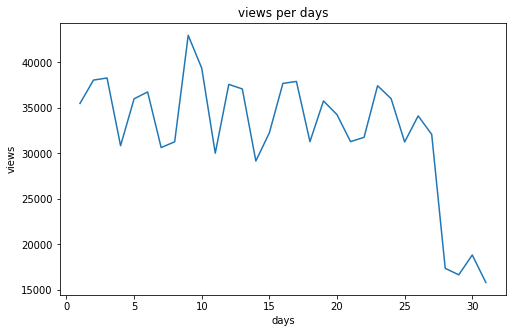

In [ ]:
# 일자 별 전체 회원 view 수.
# days_dict = {idx: vls for idx, vls in zip(df.d.map(lambda x: int(x)).value_counts().index, df.d.map(lambda x: int(x)).value_counts().values)}
# plt.plot([days_dict[x] for x in range(1,32)])
plt.plot(df.d.map(lambda x: int(x)).value_counts().sort_index())
plt.xlabel('days')
plt.ylabel('views')
plt.title('views per days')

막바지에 거의 안들어온 것을 볼 수 있음 어떤 현상인지 체크해봐야 함

In [ ]:
# 3, 4월 중 쏠린 달이 있는지 파악
df[df['d'].map(lambda x: int(x))>25]['m'].value_counts()

03    108987
04     25968
Name: m, dtype: int64

In [ ]:
df[df['d'].map(lambda x: int(x))<6]['m'].value_counts()

04    93293
03    85426
Name: m, dtype: int64

In [ ]:
df[(df['d'].map(lambda x: int(x))>25)&(df['m'].map(lambda x: int(x))==4)]['d'].value_counts()

26    11517
27     8844
30     3266
29     1345
28      996
Name: d, dtype: int64

In [ ]:
df[(df['d'].map(lambda x: int(x))>25)&(df['m'].map(lambda x: int(x))==3)]['d'].value_counts()

27    23252
26    22615
28    16383
31    15830
30    15582
29    15325
Name: d, dtype: int64

4월 마지막 부분에 평균보다 적게 들어온 것으로 확인되며, 데이터 수집 과정에서의 오류로 추론됨.

In [ ]:
days_dict

{5: 180319, 6: 175074, 1: 138459, 2: 134865, 4: 131920, 3: 124550, 0: 120464}

Text(0.5, 1.0, 'views per dows')

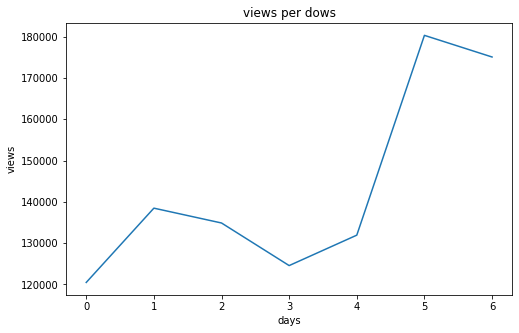

In [ ]:
# 요일 별 전체 회원 view 수.
plt.plot(df.dow.map(lambda x: int(x)).value_counts().sort_index())
plt.xlabel('days')
plt.ylabel('views')
plt.title('views per dows')

주말에 주로 많이 보는 것을 확인할 수 있음. 장르 별로 차이가 있는지 확인해볼 것

Text(0.5, 1.0, 'views per dows')

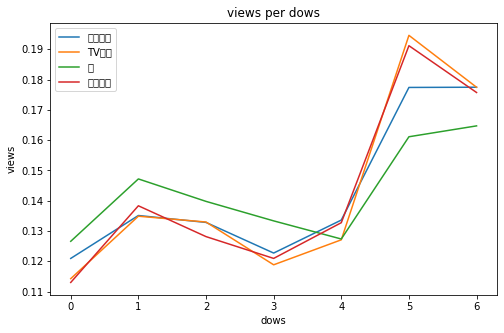

In [ ]:
# 요일 별 장르 별 추이 볼 것
for genre in ['노래율동','TV만화','책','놀이교실']:
  plt.plot(df[df['genre_mid']==genre].dow.map(lambda x: int(x)).value_counts(True).sort_index())
plt.legend(['노래율동','TV만화','책','놀이교실'])
plt.xlabel('dows')
plt.ylabel('views')
plt.title('views per dows')

특별히 요일에 따른 장르 추이 변화는 없음.

Text(0.5, 1.0, 'views per times')

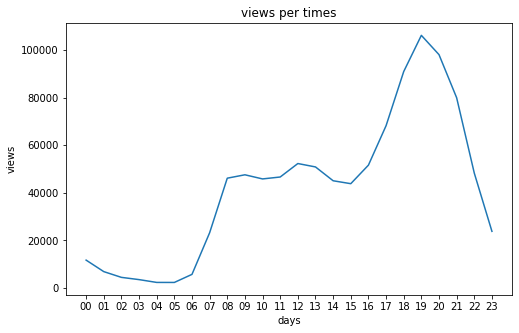

In [ ]:
# 시간 별 전체 회원 view 수.
plt.plot(df.time.value_counts().sort_index())
plt.xlabel('days')
plt.ylabel('views')
plt.title('views per times')

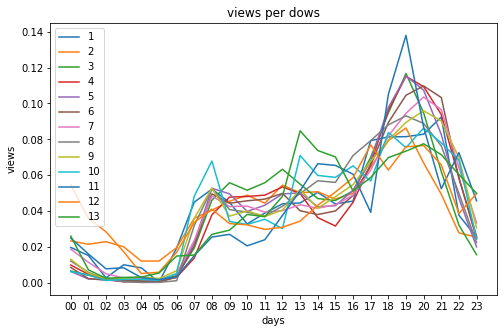

In [ ]:
# 시간 별 연령 별 회원 view 수.
for age in range(1,14):
  plt.plot(df[df['age']==age].time.value_counts(True).sort_index())
plt.legend([1,2,3,4,5,6,7,8,9,10,11,12,13])
plt.xlabel('days')
plt.ylabel('views')
plt.title('views per dows')
plt.show()

시간에 따른 연령 별 특징은 따로 없었음.

### 유저 성별 EDA

In [ ]:
# 성별 분포
profile_df.sex.value_counts()

F    4431
M    3880
Name: sex, dtype: int64

In [ ]:
# int로 치환
df['sex'] = df.sex.map(lambda x: 1 if x == 'M' else 0)

In [ ]:
# 성별에 따른 평균 view를 파악
df[['profile_id','sex','views']].drop_duplicates().groupby('sex')['views'].mean()

sex
0    117.858948
1    124.592268
Name: views, dtype: float64

성별에서 크게 view 차이는 없음

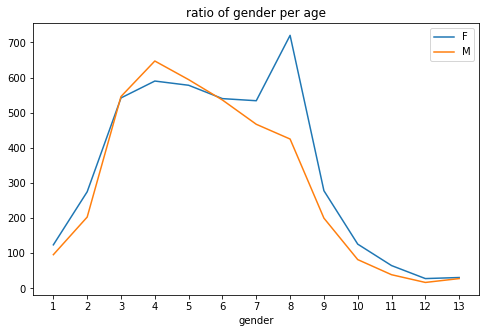

In [ ]:
#성에 따른 연령 분포
for gender in profile_df['sex'].unique():
  plt.plot(profile_df[profile_df['sex']==gender]['age'].value_counts().sort_index())
plt.xlabel('gender')
plt.title('ratio of gender per age')
plt.legend(['F','M'])
plt.xticks(range(1,14))

plt.show()


In [ ]:
df[['pr_interest_keyword_cd_1','sex','age']].corr()

,sex,age
sex,1.000000,0.116593
age,0.116593,1.000000


In [ ]:
pd.crosstab(df['sex'],df['genre_mid'])

genre_mid,MCN,TV만화,극장판 애니,노래 율동,노래율동,놀이교실,다큐멘터리,독서동화,드라마,수학과학,...,예술,외국어,유아애니,육아정보,창의학습,책,체육안전,코미디,한글,한자
sex,,,,,,,,,,,,,,,,,,,,,
0,239,107718,318,1473,244478,36190,181,2030,662,162,...,0,20147,240,516,1444,93172,9,447,167,1
1,669,131944,466,2036,177855,38662,215,743,214,527,...,3,23135,595,438,1888,77158,45,1430,280,4


In [ ]:
from scipy.stats import chi2_contingency
#카이제곱 통계치 가져오기
x2 = chi2_contingency(pd.crosstab(df['sex'],df['genre_mid']), correction = False)[0]

# n =len()

In [ ]:
# data = np.array([[7,12],[9,8]])
n = np.sum(pd.crosstab(df['sex'],df['genre_mid']).values)
minDim = min(pd.crosstab(df['sex'],df['genre_mid']).shape)-1
V = np.sqrt((x2/n) / minDim)
print(V)

0.14574670663059125


성별은 큰 특징이 없는 것으로 보임.   
크래머 V 구하기: https://www.statology.org/cramers-v-in-python/

결론적으로 1차 실험용으로 남길 features는 아래와 같음
* profile_id: 유저 식별
* album_id: 아이템 식별
<!-- * continuous_play: 연속 시청
  * 연속시청의 약한 양의 상곤관계를 확인했음 -->
* age(con): 유저 나이
* views(con): 유저의 기록정보
* genre_mid(cat): 아이템 정보
* run_time(con): 아이템 정보


In [ ]:
#view 수가 적은 연령대가 있는지 확인
print(len(df[df['views']<5]))
print(df[['profile_id','views']].drop_duplicates().views.mean())

2478
121.00240644928408


In [ ]:
df[df['views']<2]

,profile_id,album_id,sex,age,genre_mid,run_time,views
2947,26,1877,1,7,놀이교실,668,1
3472,74,2159,1,2,MCN,888,1
6085,136,16,0,2,노래율동,105,1
12133,321,306,0,6,놀이교실,800,1
16656,417,383,0,8,책,789,1
...,...,...,...,...,...,...,...
997227,32476,136,1,3,노래율동,185,1
998771,32608,339,1,5,책,755,1
1001510,32736,3342,1,11,TV만화,416,1
1005293,32982,19,1,5,노래율동,90,1


세분화를 할 경우엔 해당 평균치를 웃돌지 못하는 건들에 대해 처리하는 방식으로 진행


## NCF, DCN, DeepFM 진행
전체로 학습 진행해보고, 이후엔 

In [ ]:
!pip install -q tensorflow-recommenders

     |████████████████████████████████| 89 kB 3.3 MB/s 


#### DCN 모델링 시작


In [ ]:
import os
import sys
import gc
import glob
import joblib
from google.colab import drive
from tqdm import tqdm

import numpy as np
import pandas as pd

import keras
import tensorflow as tf
import tensorflow_recommenders as tfrs

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, Callback
from tensorflow.keras.utils import plot_model

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_datasets as tfds
import pandas as pd

#### Model Input 값 및 User, Item feature 테이블 설정

* 필요 특성을 미리 데이터셋에 추가해준다.
* 추후 추천 진행을 위해 유저 및 상품의 고유한 특성 목록을 생성한다.

  * 유저 Features: 
    * UserId(고객ID) 
    * r_counts(유저의 리뷰 총 개수)
    * pet(반려동물 유무)
  * 상품 Features: 
    * ProductId(상품ID)
    * r_counts_pro(상품의 리뷰 개수)
    * review_len_average(상품 리뷰의 평균 길이)
---
* 변경 후

  * 유저 Features: 
    * profile_id(유저 ID) 
    * age(유저의 나이)
    * views: 유저의 방문 횟수(loyalty)
  * 상품 Features: 
    * album_id (상품ID)
    * genre_mid (상품 장르)
    * run_time (상품 길이)


In [ ]:
# 필요없는 column 삭제
df = df.drop(columns=['continuous_play','m','d','time','dow','pr_interest_keyword_cd_1','ch_interest_keyword_cd_1'])

In [ ]:
df.head(3)

,profile_id,album_id,sex,age,genre_mid,run_time,views
0,3,15,0,5,노래율동,46,21
1,3,16,0,5,노래율동,105,21
2,3,17,0,5,노래율동,76,21


In [ ]:
str_features = ['profile_id','album_id','sex','genre_mid']
int_features = ['age','run_time','views']

인풋용 데이터 생성하기

In [ ]:
df['label'] = 1

In [ ]:
class model(tfrs.Model):
    """
    model class로 tfrs.Model을 상속해 call함수를 통해 모델 아키텍쳐 생성 

    """


    def __init__(self, deep_layer_sizes, learning_rate, str_features, int_features, vocabularies, projection_dim = None, metric = 'binary'):
        super().__init__()
    
        self.embedding_dimension = 64
    
        self._all_features = str_features + int_features
        self._embeddings = {}
    
        # Compute embeddings for string features.
        for feature_name in str_features:
            vocabulary = vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                [tf.keras.layers.experimental.preprocessing.StringLookup(
                    vocabulary=vocabulary, mask_token=None),
                    tf.keras.layers.Embedding(len(vocabulary) + 1,
                    self.embedding_dimension)])
          
    
        # Compute embeddings for int features.
        for feature_name in int_features:
            vocabulary = vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                [tf.keras.layers.experimental.preprocessing.IntegerLookup(
                    vocabulary=vocabulary, mask_value=None),
                    tf.keras.layers.Embedding(len(vocabulary) + 1,self.embedding_dimension)])
        
        # Cross layer

        self._cross_layer = tfrs.layers.dcn.Cross(
            projection_dim = projection_dim,
            kernel_initializer = "glorot_uniform") 
            
        # Deep layer
        self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
            for layer_size in deep_layer_sizes]
        
        # Output layer
        self._logit_layer = tf.keras.layers.Dense(1,activation = 'sigmoid')
        # Metric
        if metric == 'binary':
            self.task = tfrs.tasks.Ranking(
            loss = tf.keras.losses.BinaryCrossentropy(),
            metrics=[
                    tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype = None, threshold = 0.5)])
    
    def call(self, features):
        # Concatenate embeddings
        embeddings = []
        for feature_name in self._all_features:
            embedding_fn = self._embeddings[feature_name]
            embeddings.append(embedding_fn(features[feature_name]))
    
        x = tf.concat(embeddings, axis=1)
    
        # Build Cross Network
        cross_layer = self._cross_layer
        x = cross_layer(x)
        
        # Build Deep Network
        for deep_layer in self._deep_layers:
            x = deep_layer(x)

        return self._logit_layer(x)
    
    def compute_loss(self, features, training=False, metric = 'binary'):
        if metric == 'binary':
            labels = features.pop("label")
        scores = self(features)
    
        return self.task(labels=labels,predictions=scores)

In [ ]:
import os
import sys
import gc
import glob
import joblib
from tqdm import tqdm

import ast
import numpy as np
import pandas as pd

import keras
import tensorflow as tf


def DCN(df, str_features, int_features, df_type = 'train'):
"""
인풋값을 만들기 위한 함수.
train용과 test용으로 나뉘어져있음.
"""

    feature_names = str_features + int_features

    # feature type 변경
    def setType(df):
        for f in str_features:
            if df[f].dtype == float:
                df[f] = df[f].astype(int)

        for f in int_features:
            df[f] = df[f].astype(int)
            
        return df
  
    # 데이터 dict로 변환
    def generateDict(df):
        # str features는 encoding
        train_str_dict = {str_feature: [str(val).encode() for val in df[str_feature].values]for str_feature in str_features}
        # int features는 int
        train_int_dict = {int_feature: df[int_feature].valuesfor int_feature in int_features}

        # # label columns이 있다면~
        try:
            train_label_dict = {'label' : df['label'].values}
            train_str_dict.update(train_label_dict)
        except:
            pass

        train_str_dict.update(train_int_dict)
        return train_str_dict


    df_copy = setType(df)
    input_dict = generateDict(df_copy)

    # tensor
    tensor = tf.data.Dataset.from_tensor_slices(input_dict)
    cached = tensor.shuffle(100_000).batch(8192).cache()
    # unique data 저장
    # train data 일 때, 
    if df_type == 'train':
        vocabularies = {}
    
        for feature_name in tqdm(feature_names):
            vocab = tensor.batch(1_000_000).map(lambda x: x[feature_name])
            vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))
    
        return cached, vocabularies
      
      # test data 일 때, 
    else:
        return cached

In [ ]:
#view 수가 적은 연령대가 있는지 확인
print(len(df[df['views']<5]))
print(df[['profile_id','views']].drop_duplicates().views.mean())

2478
121.00240644928408


In [ ]:
# 성별에 따른 전체 평균 views차이
df[['profile_id','sex','views']].groupby


,profile_id,views
sex,,
0,13655.737334,1468.580252
1,13212.544558,1097.424362


In [ ]:
# import scipy.stats as stats
# # 성별에 따른 
# stats.pointbiserialr(x, y)

In [ ]:
df.columns

Index(['profile_id', 'album_id', 'continuous_play', 'm', 'd', 'time', 'dow',
       'sex', 'age', 'pr_interest_keyword_cd_1', 'ch_interest_keyword_cd_1',
       'genre_mid', 'run_time', 'views'],
      dtype='object')

In [ ]:
df[df['age']==13]['views'].mean()

11232.818533037895

In [ ]:
df.columns

Index(['profile_id', 'album_id', 'continuous_play', 'm', 'd', 'time', 'dow',
       'sex', 'age', 'pr_interest_keyword_cd_1', 'ch_interest_keyword_cd_1',
       'genre_mid', 'run_time'],
      dtype='object')

In [ ]:
print(history_df.shape)
print(buy_df.shape)

(1005651, 8)
(150, 6)


In [ ]:
watch_df.shape

(892794, 8)

In [ ]:
history_df.shape

(1005651, 8)

In [ ]:
watch_df.head(3)

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
0,3,20220301115653,20220301115805,MKID049,15,46,46,1
1,3,20220301115653,20220301115954,MKID049,16,104,105,1
2,3,20220301115653,20220301120114,MKID049,17,76,76,1


In [ ]:
import seaborn as sns
watch_df.continuous_play.value_counts()

1    500524
0    312677
2     79424
3       169
Name: continuous_play, dtype: int64

절반 이상은 연속재생을 실행하고 있음. 연속재생을 하는 상품과 아닌상품을 비교해볼 것

In [ ]:
meta_df.head(3)

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
0,749,어둠이 무서워요,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
1,750,우리는 친구,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
2,2131,타요의 첫 운행,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN


In [ ]:
#상품 중복정보 확인
meta_df.album_id.value_counts()

8231     4
4083     4
4932     4
5314     4
3843     4
        ..
16963    1
32433    1
32434    1
32435    1
11629    1
Name: album_id, Length: 39875, dtype: int64

In [ ]:
meta_df[(meta_df['album_id']==8231)|(meta_df['album_id']==4083)]

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
7904,4083,나비의 왈츠,개구리야 안녕?,키즈,노래율동,NaN,NaN,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7905,4083,나비의 왈츠,노래율동,키즈,노래율동,NaN,NaN,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7906,4083,나비의 왈츠,만 3세를 위한 영상,키즈,노래율동,NaN,NaN,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7907,4083,나비의 왈츠,핑크퐁 곤충동요,키즈,노래율동,NaN,NaN,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13526,8231,알록달록 물고기,노래율동,키즈,노래율동,NaN,한국,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13527,8231,알록달록 물고기,만 3세를 위한 영상,키즈,노래율동,NaN,한국,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13528,8231,알록달록 물고기,만 4세를 위한 영상,키즈,노래율동,NaN,한국,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13529,8231,알록달록 물고기,트니트니 율동 바다스페셜,키즈,노래율동,NaN,한국,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sub title에 의해 중복 발생 확인, sub title feature 제거 후 전체 중복 제거

In [ ]:
# 아이템 프로필 축소
meta = meta_df[['album_id','genre_large','genre_mid','run_time']]

In [ ]:
meta.genre_mid.nunique()

29

In [ ]:
# 유저 프로필은 키워드 1번까지만 남기기
profile = profile_df.drop(columns= ['pr_interest_keyword_cd_2','pr_interest_keyword_cd_3','ch_interest_keyword_cd_2','ch_interest_keyword_cd_3'])

In [ ]:
meta_df[meta_df['album_id']==16]

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
9032,16,상어 가족,노래율동,키즈,노래율동,NaN,NaN,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9033,16,상어 가족,핑크퐁 3D율동동요,키즈,노래율동,NaN,NaN,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(len(watch_df[watch_df['left_time']>1000]))
print(len(watch_df[watch_df['left_time']<=1000]))

12485
880309


<AxesSubplot:ylabel='Density'>

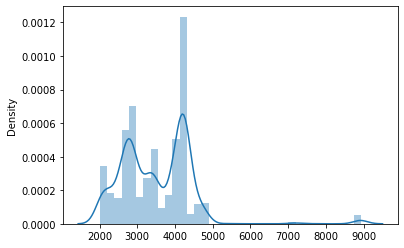

In [ ]:
sns.distplot(watch_df[watch_df['left_time']>2000].left_time.values)

left time이 2000이상인 팀은 낮은 편이긴 하지만, 이걸로 뭔가 다른 집단과의 비교를 위해 해당 집단에서 연속 여부를 보면 됨

<AxesSubplot:ylabel='Density'>

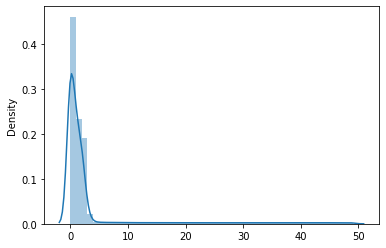

In [ ]:
sns.distplot(watch_df[watch_df['left_time']<50].left_time.values)

0의 빈도가 대부분 == 그 만큼 left time은 낮을 수록 빈도가 높다

<AxesSubplot:xlabel='total_time', ylabel='Density'>

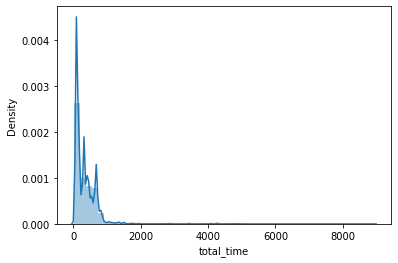

In [ ]:
sns.distplot(watch_df['total_time'])

확실히 total time도 1400아래까지가 높은 편(IQR로 확인해볼 것)

In [ ]:
#길이가 연속성과 관계가 있는지 보자.
watch_df['continuous_play'].value_counts()

1    500524
0    312677
2     79424
3       169
Name: continuous_play, dtype: int64

In [ ]:
# countinous play를 binary하게 변경
watch_df['continuous_play'] = watch_df['continuous_play'].map(lambda x: 0 if (x == 0) or (x == 2) or (x == 3) else x)

In [ ]:
watch_df[['total_time','continuous_play']].corr()

,total_time,continuous_play
total_time,1.000000,-0.197325
continuous_play,-0.197325,1.000000


총 영상 길이와 연속 재생은 약한 음의 상관 관계가 있는 것을 확인.

<AxesSubplot:>

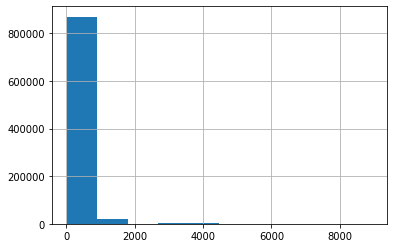

In [ ]:
watch_df['total_time'].hist()

<AxesSubplot:>

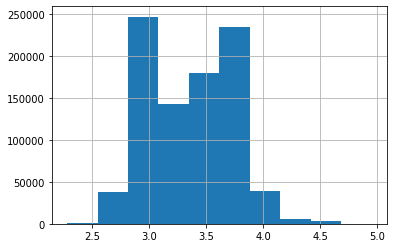

In [ ]:
# watch_df의 왜도 감소를 위해 log를 씌워 확인해보기

watch_df['total_time_logged'] = watch_df['total_time'].map(lambda x: np.log10(x)+1)
watch_df['total_time_logged'].hist()

In [ ]:
watch_df[['total_time_logged','continuous_play']].corr()

,total_time_logged,continuous_play
total_time_logged,1.00000,-0.22526
continuous_play,-0.22526,1.00000


아주 약한 음의 상관관계를 가지는것을 볼 수 있음

In [ ]:
watch_df.columns

Index(['profile_id', 'ss_id', 'log_time', 'act_target_dtl', 'album_id',
       'watch_time', 'total_time', 'continuous_play', 'left_time'],
      dtype='object')

In [ ]:
w_df = pd.merge(watch_df,profile_df, 'left', on = 'profile_id')

In [ ]:
meta_df.head(3)

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
0,749,어둠이 무서워요,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
1,750,우리는 친구,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
2,2131,타요의 첫 운행,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN


In [ ]:
df[df['payment'].notnull()]

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer,genre_large,genre_mid,run_time
50,5,20220306110942,20220306114207,MKID003,84,5040.0,Y,N,키즈,노래율동,98
132,5,20220309185728,20220309192310,MKID003,84,5040.0,Y,N,키즈,노래율동,98
158,5,20220310180411,20220311081432,MKID003,84,5040.0,Y,N,키즈,노래율동,98
253,5,20220321193733,20220321194826,MKID003,178,5040.0,Y,N,키즈,노래율동,100
260,5,20220321193733,20220321200352,MKID003,178,5040.0,Y,N,키즈,노래율동,100
...,...,...,...,...,...,...,...,...,...,...,...
1275309,33032,20220427110951,20220427111964,MKID003,350,14000.0,Y,N,애니,시리즈,720
1275310,33032,20220427112116,20220427112300,MKID003,466,14000.0,N,N,애니,액션/모험,705
1275316,33032,20220427112116,20220427112409,MKID003,673,20000.0,N,N,키즈,TV만화,100
1275320,33032,20220427112116,20220427112496,MKID003,674,20000.0,N,N,키즈,TV만화,322


In [ ]:
w_df[['age','continuous_play']].corr()

,age,continuous_play
age,1.000000,-0.181977
continuous_play,-0.181977,1.000000


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# d = watch_df[['total_time_logged','continuous_play']]
# t,v = train_test_split(watch_df, test_size = 0.2, random_state = 2)
t,v = train_test_split(w_df, test_size = 0.2, random_state = 2)

In [ ]:
logit = LogisticRegression()
logit.fit(t[['age']], t[['continuous_play']])

LogisticRegression()

In [ ]:
logit.fit(t[['total_time_logged']], t[['continuous_play']])

LogisticRegression()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
pred = logit.predict(v[['age']])

print(confusion_matrix(pred, v[['continuous_play']]))
print(classification_report(pred, v[['continuous_play']]))

[[23019 18016]
 [55539 81985]]
              precision    recall  f1-score   support

           0       0.29      0.56      0.38     41035
           1       0.82      0.60      0.69    137524

    accuracy                           0.59    178559
   macro avg       0.56      0.58      0.54    178559
weighted avg       0.70      0.59      0.62    178559



In [ ]:
history_df.head(10)

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
0,3,20220301115653,20220301115719,MKID003,15,NaN,Y,N
1,3,20220301115653,20220301115809,MKID003,16,NaN,Y,N
2,3,20220301115653,20220301115958,MKID003,17,NaN,Y,N
3,3,20220301115653,20220301120118,MKID003,18,NaN,Y,N
4,3,20220301115653,20220301120229,MKID003,19,NaN,Y,N
5,3,20220301115653,20220301120450,MKID003,20,NaN,Y,N
6,3,20220301115653,20220301120654,MKID003,21,NaN,Y,N
7,3,20220301115653,20220301120859,MKID003,22,NaN,Y,N
8,3,20220301115653,20220301121104,MKID003,23,NaN,Y,N
9,3,20220301115653,20220301121308,MKID003,24,NaN,Y,N


In [ ]:
# 세션이 중복되면서 album_id가 중복되는 경우 확인
history_df[['ss_id','album_id']].duplicated().value_counts()

False    670661
True     334990
dtype: int64

다시 보는 경우도 존재

In [ ]:
history = history[['profile_id','']]

In [ ]:
df = pd.merge(history_df, meta, "left", on = 'album_id')

In [ ]:
df_watch = pd.merge(watch_df, meta_df, "left", on = 'album_id')

In [ ]:
df_watch[df_watch['continuous_play']==1]['']

In [ ]:
df.head(3)

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer,title,sub_title,...,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
0,3,20220301115653,20220301115719,MKID003,15,NaN,Y,N,거미,핑크퐁 3D율동동요,...,NaN,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,20220301115653,20220301115809,MKID003,16,NaN,Y,N,상어 가족,노래율동,...,NaN,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,20220301115653,20220301115809,MKID003,16,NaN,Y,N,상어 가족,핑크퐁 3D율동동요,...,NaN,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd
from dython.nominal import associations


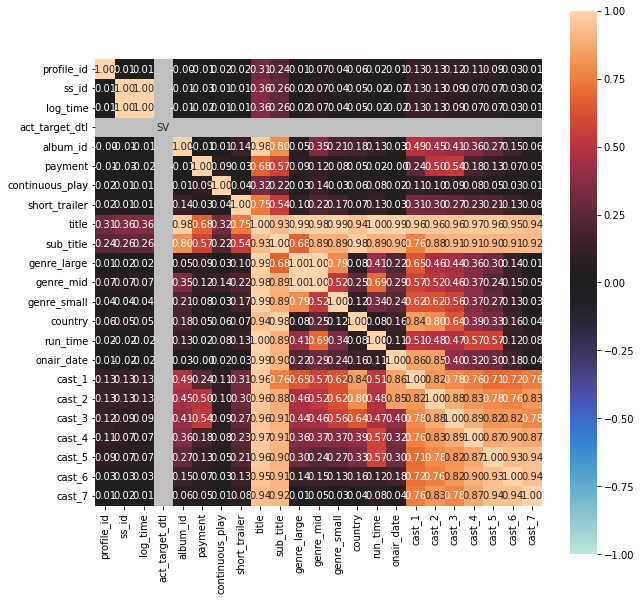

In [ ]:
complete_correlation= associations(df, filename= 'complete_correlation.png', figsize=(10,10))

In [ ]:
df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

In [ ]:
df.shape

(1275380, 23)

In [ ]:
df.columns

Index(['profile_id', 'ss_id', 'log_time', 'act_target_dtl', 'album_id',
       'payment', 'continuous_play', 'short_trailer', 'title', 'sub_title',
       'genre_large', 'genre_mid', 'genre_small', 'country', 'run_time',
       'onair_date', 'cast_1', 'cast_2', 'cast_3', 'cast_4', 'cast_5',
       'cast_6', 'cast_7'],
      dtype='object')

In [ ]:
|watch_df[watch_df['continuous_play']==1]

In [ ]:
watch_df.head(3)

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
0,3,20220301115653,20220301115805,MKID049,15,46,46,1
1,3,20220301115653,20220301115954,MKID049,16,104,105,1
2,3,20220301115653,20220301120114,MKID049,17,76,76,1


In [ ]:
sns.distplot(meta_df.run_time)

plt.rcParams['figure.figsize'] = (15,15)

In [ ]:
meta_df.columns

Index(['album_id', 'title', 'sub_title', 'genre_large', 'genre_mid',
       'genre_small', 'country', 'run_time', 'onair_date', 'cast_1', 'cast_2',
       'cast_3', 'cast_4', 'cast_5', 'cast_6', 'cast_7'],
      dtype='object')

In [ ]:
buy_df

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment
0,255,20220426153942,20220426154128,MKID004,3767,500
1,1603,20220309163919,20220309164043,MKID004,1640,300
2,5303,20220411080324,20220411082725,MKID004,3821,500
3,5303,20220411080324,20220411084013,MKID004,3822,500
4,5303,20220411080324,20220411085607,MKID004,3823,500
...,...,...,...,...,...,...
145,23882,20220421182514,20220421185231,MKID004,7441,300
146,23882,20220421182514,20220421185510,MKID004,8749,1200
147,31509,20220409115246,20220409115347,MKID004,19906,500
148,31837,20220427143436,20220427143618,MKID004,1640,300


* Buy data는 샘플 수가 너무 적어서 크게 사용할 이유가 없음

In [ ]:
# 연속으로 보는지 여부 확인
history_df.continuous_play.value_counts()

Y    889517
N    116134
Name: continuous_play, dtype: int64

In [ ]:
# 예고편을 보는지 여부 확인
history_df.short_trailer.value_counts()

N    945784
Y     59867
Name: short_trailer, dtype: int64

In [ ]:
watch_df.shape

(892794, 8)

In [ ]:
watch_df.head(3)

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
0,3,20220301115653,20220301115805,MKID049,15,46,46,1
1,3,20220301115653,20220301115954,MKID049,16,104,105,1
2,3,20220301115653,20220301120114,MKID049,17,76,76,1


In [ ]:
# 컨텐츠 시간 대비 본시간 차이를 컬럼으로 생성
watch_df['left_time'] = watch_df['total_time'] - watch_df['watch_time']

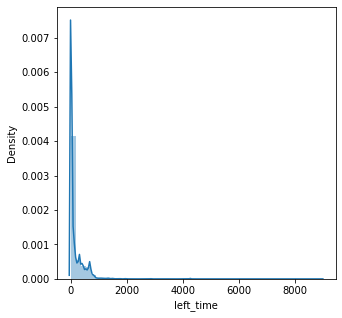

In [ ]:
sns.distplot(watch_df['left_time'])
plt.rcParams['figure.figsize'] = (5,5)

In [ ]:
plt.rcParams['figure.figsize'] = (15,15)

In [ ]:
watch_df['left_time'].sort_values()

0            0
240118       0
240117       0
240116       0
240115       0
          ... 
618846    8924
562555    8925
594325    8925
723568    8926
214676    8927
Name: left_time, Length: 892794, dtype: int64

In [ ]:
watch_df[watch_df['left_time']>8900]

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play,left_time
214676,5345,20220409083441,20220409093525,MKID049,15440,0,8927,0,8927
562555,16234,20220410200445,20220410201214,MKID049,15440,2,8927,0,8925
582099,17066,20220413183249,20220413223330,MKID049,15440,15,8929,0,8914
582100,17066,20220413183249,20220413223348,MKID049,15440,15,8927,0,8912
582101,17066,20220413183249,20220413223406,MKID049,15440,15,8927,0,8912
582102,17066,20220413183249,20220413223424,MKID049,15440,15,8927,0,8912
582103,17066,20220413183249,20220413223442,MKID049,15440,15,8929,0,8914
582104,17066,20220413183249,20220413223500,MKID049,15440,15,8927,0,8912
582105,17066,20220413183249,20220413223518,MKID049,15440,15,8927,0,8912
582106,17066,20220413183249,20220413223536,MKID049,15440,15,8929,0,8914


In [ ]:
for i in 
  watch_df[watch_df['total_time']]

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play,left_time
666,20,20220322154457,20220322160741,MKID049,444,21,4721,0,4700
3191,63,20220301093203,20220301094131,MKID049,2329,0,4200,0,4200
8224,195,20220423002654,20220423113033,MKID049,332,0,4093,0,4093
10864,302,20220317194292,20220317200401,MKID049,3460,13,4769,0,4756
10865,302,20220317194292,20220317200401,MKID049,3460,13,4769,0,4756
...,...,...,...,...,...,...,...,...,...
884874,32443,20220314071230,20220314171416,MKID049,332,819,4093,0,3274
885774,32554,20220301210553,20220301222142,MKID049,4200,470,4091,2,3621
885775,32554,20220301210553,20220302084328,MKID049,332,157,4093,0,3936
886671,32631,20220315084052,20220315084244,MKID049,332,88,4093,0,4005


In [ ]:
profile_df.head(3)

,profile_id,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,F,5,P02,P04,P07,K01,K03,K04
1,5,M,5,P07,P08,P06,K05,K08,K09
2,7,F,9,P05,P03,NaN,K06,K04,NaN


In [ ]:
meta_df.head(3)

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
0,749,어둠이 무서워요,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
1,750,우리는 친구,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
2,2131,타요의 첫 운행,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN


In [ ]:
print(history_df.shape)
print(profile_df.shape)
print(meta_df.shape)

(1005651, 8)
(8311, 9)
(42602, 16)


### 학습 및 검증 데이터 생성 
- train : 시청 이력의 80%를 사용 
- valid : 시청 이력의 20%를 사용 

In [ ]:
# 데이터 전처리 (중복제거) 
# 참고 : drop_duplicates의 subset을 무엇으로 구성하냐에 따라서 제거되는 항목들이 다름 
# ex) 'profile_id', 'album_id' : 중복된 시청이력 모두 제거 / 'profile_id', 'album_id', 'log_time' : 같은 시간에 시청한 이력만 제거 
data = history_df[['profile_id', 'log_time', 'album_id']].drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).sort_values(by = ['profile_id', 'log_time']).reset_index(drop = True)
data['rating'] = 1


In [ ]:
data.head(3)

,profile_id,log_time,album_id,rating
0,3,20220301115719,15,1
1,3,20220301115809,16,1
2,3,20220301115958,17,1


In [ ]:
cfg.n_users = data.profile_id.max()+1
cfg.n_items = data.album_id.max()+1


In [ ]:
# 학습 및 검증 데이터 분리
train, valid = train_test_split(
    data, test_size=cfg.test_size, random_state=cfg.seed,
)
print('학습 데이터 크기:', train.shape)
print('검증 데이터 크기:', valid.shape)

학습 데이터 크기: (719401, 4)
검증 데이터 크기: (179851, 4)


In [ ]:
sparse.lil_matrix((cfg.n_users, cfg.n_items))

<33033x25917 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in List of Lists format>

In [ ]:
train.to_numpy()

array([[          2367, 20220422085064,           3508,              1],
       [         16852, 20220323091402,           1992,              1],
       [         16213, 20220424020218,           2032,              1],
       ...,
       [          3460, 20220422202806,           4924,              1],
       [         20590, 20220402194102,            831,              1],
       [          3256, 20220327223337,             94,              1]])

In [ ]:
# Matrix 형태로 변환 
train = train.to_numpy()
matrix = sparse.lil_matrix((cfg.n_users, cfg.n_items))
for (p, _, i, r) in tqdm(train):
    matrix[p, i] = r
    
train = sparse.csr_matrix(matrix)
train = train.toarray()
print("train 형태: \n", train)

  0%|          | 0/719401 [00:00<?, ?it/s]

train 형태: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# 유저 특징 정보 추출 
profile_df = profile_df.set_index('profile_id')
user_features = profile_df[['age']].to_dict()
print("user_id 3의 age 정보 :", user_features['age'][3])

user_id 3의 age 정보 : 5


In [ ]:
meta_df.head(3)

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
0,749,어둠이 무서워요,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
1,750,우리는 친구,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
2,2131,타요의 첫 운행,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN


In [ ]:
# 아이템 특징 정보 추출 
meta_df = meta_df.set_index('album_id')

# 범주형 데이터를 수치형 데이터로 변경 
le = LabelEncoder()
meta_df['genre_mid'] = le.fit_transform(meta_df['genre_mid'])
item_features = meta_df[['genre_mid']].to_dict()
print("album_id 749의 genre_mid 정보 :", item_features['genre_mid'][749])

album_id 749의 genre_mid 정보 : 1


In [ ]:
# 추출한 특징 정보의 속성을 저장 
cfg.n_genres = meta_df['genre_mid'].nunique()
cfg.n_continuous_feats = 1 

## NeuMF 구현


### 모델 구현 
- [Neural Collaborative Filtering(NCF)](https://arxiv.org/pdf/1708.05031.pdf) 논문의 NeuMF를 참고하여 side-information을 결합한 모델을 PyTorch로 구현
    - continuous feature (age)와 categorical feature (genre_mid)를 같이 학습할 수 있도록 결합

![](http://drive.google.com/uc?export=view&id=1tpajTLipLoFdvLICO-alAxeoKAE8-k61)

In [ ]:
class NeuMF(nn.Module):
    """Neural Matrix Factorization Model
        참고 문헌 : https://arxiv.org/abs/1708.05031

    예시 :
        model = NeuMF(cfg) 
        output = model.forward(user_ids, item_ids, [feat0, feat1]) 
    """
    def __init__(self, cfg):
        """ 
        Args:
            cfg : config 파일로 네트워크 생성에 필요한 정보들을 담고 있음 
        """
        super(NeuMF, self).__init__()
        self.n_users = cfg.n_users
        self.n_items = cfg.n_items
        self.emb_dim = cfg.emb_dim
        self.layer_dim = cfg.layer_dim
        self.n_continuous_feats = cfg.n_continuous_feats
        self.n_genres = cfg.n_genres
        self.dropout = cfg.dropout
        self.build_graph()

    def build_graph(self):
        """Neural Matrix Factorization Model 생성
            구현된 모습은 위의 그림을 참고 
        """
        # mf용 유저임베딩 - 유저 임베딩 수 == 유저 cfg 수, 임베딩 차원 수 == 256 
        self.user_embedding_mf = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mf = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
        
        # mlp 용 유저 임베딩, 차원 수도 동일한 방법
        self.user_embedding_mlp = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mlp = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
                
        # mlp 용 특성 장르 임베딩도 설정
        self.genre_embeddig = nn.Embedding(num_embeddings=self.n_genres, embedding_dim=self.n_genres//2)
        
        # mlp 레이어 - 시퀜셜 모델로 생성
        self.mlp_layers = nn.Sequential(
            # 첫번째 인자값은 input size, 두번째 인자값은 output size이다
            nn.Linear(2*self.emb_dim + self.n_genres//2 + self.n_continuous_feats, self.layer_dim), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout), 
            nn.Linear(self.layer_dim, self.layer_dim//2), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout)
        )
        
        self.affine_output = nn.Linear(self.layer_dim//2 + self.emb_dim, 1)
        self.apply(self._init_weights)
        

    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            normal_(module.weight.data, mean=0.0, std=0.01)
        elif isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
    
    def forward(self, user_indices, item_indices, feats):
        """ 
        Args:
            user_indices : 유저의 인덱스 정보 
                ex) tensor([ 3100,  3100,  ..., 14195, 14195])
            item_indices : 아이템의 인덱스 정보
                ex) tensor([   50,    65,   ..., 14960, 11527])
            feats : 특징 정보 
        Returns: 
            output : 유저-아이템 쌍에 대한 추천 결과 
                ex) tensor([  9.4966,  22.0261, ..., -19.3535, -23.0212])
        """
        # 임베딩 진행
        user_embedding_mf = self.user_embedding_mf(user_indices)
        item_embedding_mf = self.item_embedding_mf(item_indices)
        mf_output = torch.mul(user_embedding_mf, item_embedding_mf)
        
        user_embedding_mlp = self.user_embedding_mlp(user_indices)
        item_embedding_mlp = self.item_embedding_mlp(item_indices)
        genre_embedding_mlp = self.genre_embeddig(feats[1])
        input_feature = torch.cat((user_embedding_mlp, item_embedding_mlp, genre_embedding_mlp, feats[0].unsqueeze(1)), -1)
        mlp_output = self.mlp_layers(input_feature)
        
        output = torch.cat([mlp_output, mf_output], dim=-1)
        output = self.affine_output(output).squeeze(-1)
        return output

### 학습 및 추론 코드 구현

- 학습 : Negative sampling을 활용하여 Binary Classification 진행 
    - history 에 있는 album_id는 positive label로 그렇지 않은 album_id는 nagative label로 활용  
    - 단, 이때 모든 album_id를 negative label로 활용하는 것이 아닌 일부만 사용 (neg_ratio 값에 따라서 개수 조정)
- 추론 : 일부 데이터에 대해 recall, ndcg, coverage 성능 확인

#### 학습 및 추론에 필요한 데이터 셋 생성 코드 구현

In [ ]:
def make_UIdataset(train, neg_ratio):
    """ 유저별 학습에 필요한 딕셔너리 데이터 생성 
    Args:
        train : 유저-아이템의 상호작용을 담은 행렬 
            ex) 
                array([[0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        ...,
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.]])
        neg_ratio : negative sampling 활용할 비율 
            ex) 3 (positive label 1개당 negative label 3개)
    Returns: 
        UIdataset : 유저별 학습에 필요한 정보를 담은 딕셔너리 
            ex) {'사용자 ID': [[positive 샘플, negative 샘플], ... , [1, 1, 1, ..., 0, 0]]}
                >>> UIdataset[3]
                    [array([   16,    17,    18, ...,  9586, 18991,  9442]),
                    array([5, 5, 5, ..., 5, 5, 5]),
                    array([4, 4, 4, ..., 5, 1, 1]),
                    array([1., 1., 1., ..., 0., 0., 0.])]
    """
    UIdataset = {}
    for user_id, items_by_user in enumerate(train):
        UIdataset[user_id] = []
        # positive 샘플 계산 
        # pos item은 0.5 이상인 것들의 index를 찾아 출력
        pos_item_ids = np.where(items_by_user > 0.5)[0]
        # pos 샘플 개수
        num_pos_samples = len(pos_item_ids)

        # negative 샘플 계산 (random negative sampling)
        # neg 샘플 개수 
        num_neg_samples = neg_ratio * num_pos_samples
        neg_items = np.where(items_by_user < 0.5)[0]
        # neg 샘플 중 랜덤 초이스
        neg_item_ids = np.random.choice(neg_items, min(num_neg_samples, len(neg_items)), replace=False)
        # pos, neg 샘플 짝지어서 UIdataset에 넣기
        UIdataset[user_id].append(np.concatenate([pos_item_ids, neg_item_ids]))
        
        # feature 추출 
        features = []
        # pos, neg 쌍을 하나씩 뽑고,
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            # user_features의 user에 따른 나이를 features에 넣기
            features.append(user_features['age'][user_id])
        #나이 정보 순서를 append해서 모든 쌍에 추가해주기
        UIdataset[user_id].append(np.array(features))
        
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            # item_features의 item에 따른 장르를 features에 넣기
            features.append(item_features['genre_mid'][item_id])
        #장르 정보를 append해서 모든 쌍에 추가해주기 -> 상호작용에 feature가 추가된것임
        UIdataset[user_id].append(np.array(features))
        
        # label 저장  
        pos_labels = np.ones(len(pos_item_ids))
        neg_labels = np.zeros(len(neg_item_ids))
        UIdataset[user_id].append(np.concatenate([pos_labels, neg_labels]))

    return UIdataset

In [ ]:
UIdataset = make_UIdataset(train, neg_ratio=cfg.neg_ratio)

In [ ]:
def make_batchdata(user_indices, batch_idx, batch_size):
    """ 배치 데이터로 변환 
    Args:
        user_indices : 전체 유저의 인덱스 정보 
            ex) array([ 3100,  1800, 30098, ...,  2177, 11749, 20962])
        batch_idx : 배치 인덱스 (몇번째 배치인지)
            ex) 0 
        batch_size : 배치 크기 
            ex) 256 
    Returns 
        batch_user_ids : 배치내의 유저 인덱스 정보 
            ex) [22194, 22194, 22194, 22194, 22194, ...]
        batch_item_ids : 배치내의 아이템 인덱스 정보 
            ex) [36, 407, 612, 801, 1404, ...]
        batch_feat0 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature0 정보 
            ex) [6, 6, 6, 6, 6, ...]
        batch_feat1 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature1 정보 
            ex) [4,  4,  4, 23,  4, ...]
        batch_labels : 배치내의 유저-아이템 인덱스 정보에 해당하는 label 정보 
            ex) [1.0, 1.0, 1.0, 1.0, 1.0, ...]
    """
    batch_user_indices = user_indices[batch_idx*batch_size : (batch_idx+1)*batch_size]
    batch_user_ids = []
    batch_item_ids = []
    batch_feat0 = []
    batch_feat1 = []
    batch_labels = []
    for user_id in batch_user_indices:
        item_ids = UIdataset[user_id][0]
        feat0 = UIdataset[user_id][1]
        feat1 = UIdataset[user_id][2]
        labels = UIdataset[user_id][3]
        user_ids = np.full(len(item_ids), user_id)  # 모든 값을 user_id로 통일
        batch_user_ids.extend(user_ids.tolist())
        batch_item_ids.extend(item_ids.tolist())
        batch_feat0.extend(feat0.tolist())
        batch_feat1.extend(feat1.tolist())
        batch_labels.extend(labels.tolist())
    return batch_user_ids, batch_item_ids, batch_feat0, batch_feat1, batch_labels

def update_avg(curr_avg, val, idx):
    """ 현재 epoch 까지의 평균 값을 계산 
    """
    return (curr_avg * idx + val) / (idx + 1)

#### 학습 및 검증 코드 생성

In [ ]:
def train_epoch(cfg, model, optimizer, criterion): 
    model.train()
    curr_loss_avg = 0.0

    user_indices = np.arange(cfg.n_users)
    np.random.RandomState(cfg.epoch).shuffle(user_indices)
    batch_num = int(len(user_indices) / cfg.batch_size) + 1
    bar = tqdm(range(batch_num), leave=False)
    for step, batch_idx in enumerate(bar):
        user_ids, item_ids, feat0, feat1, labels = make_batchdata(user_indices, batch_idx, cfg.batch_size)
        # 배치 사용자 단위로 학습
        user_ids = torch.LongTensor(user_ids).to(cfg.device)
        item_ids = torch.LongTensor(item_ids).to(cfg.device)
        feat0 = torch.FloatTensor(feat0).to(cfg.device)
        feat1 = torch.LongTensor(feat1).to(cfg.device)
        labels = torch.FloatTensor(labels).to(cfg.device)
        labels = labels.view(-1, 1)

        # grad 초기화
        optimizer.zero_grad()

        # 모델 forward
        output = model.forward(user_ids, item_ids, [feat0, feat1])
        output = output.view(-1, 1)

        loss = criterion(output, labels)

        # 역전파
        loss.backward()

        # 최적화
        optimizer.step()    
        if torch.isnan(loss):
            print('Loss NAN. Train finish.')
            break
        curr_loss_avg = update_avg(curr_loss_avg, loss, step)
        
        msg = f"epoch: {cfg.epoch}, "
        msg += f"loss: {curr_loss_avg.item():.5f}, "
        msg += f"lr: {optimizer.param_groups[0]['lr']:.6f}"
        bar.set_description(msg)
    rets = {'losses': np.around(curr_loss_avg.item(), 5)}
    return rets

In [ ]:
def recallk(actual, predicted, k = 25):
    """ label과 prediction 사이의 recall 평가 함수 
    Args:
        actual : 실제로 본 상품 리스트
        pred : 예측한 상품 리스트
        k : 상위 몇개의 데이터를 볼지 (ex : k=5 상위 5개의 상품만 봄)
    Returns: 
        recall_k : recall@k 
    """ 
    set_actual = set(actual)
    recall_k = len(set_actual & set(predicted[:k])) / min(k, len(set_actual))
    return recall_k

def unique(sequence):
    # preserves order
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

def ndcgk(actual, predicted, k = 25):
    set_actual = set(actual)
    idcg = sum([1.0 / np.log(i + 2) for i in range(min(k, len(set_actual)))])
    dcg = 0.0
    unique_predicted = unique(predicted[:k])
    for i, r in enumerate(unique_predicted):
        if r in set_actual:
            dcg += 1.0 / np.log(i + 2)
    ndcg_k = dcg / idcg
    return ndcg_k

def evaluation(gt, pred):
    """ label과 prediction 사이의 recall, coverage, competition metric 평가 함수 
    Args:
        gt : 데이터 프레임 형태의 정답 데이터 
        pred : 데이터 프레임 형태의 예측 데이터 
    Returns: 
        rets : recall, ndcg, coverage, competition metric 결과 
            ex) {'recall': 0.123024, 'ndcg': 056809, 'coverage': 0.017455, 'score': 0.106470}
    """    
    gt = gt.groupby('profile_id')['album_id'].unique().to_frame().reset_index()
    gt.columns = ['profile_id', 'actual_list']

    evaluated_data = pd.merge(pred, gt, how = 'left', on = 'profile_id')

    evaluated_data['Recall@25'] = evaluated_data.apply(lambda x: recallk(x.actual_list, x.predicted_list), axis=1)
    evaluated_data['NDCG@25'] = evaluated_data.apply(lambda x: ndcgk(x.actual_list, x.predicted_list), axis=1)

    recall = evaluated_data['Recall@25'].mean()
    ndcg = evaluated_data['NDCG@25'] .mean()
    coverage = (evaluated_data['predicted_list'].apply(lambda x: x[:cfg.top_k]).explode().nunique())/meta_df.index.nunique()

    score = 0.75*recall + 0.25*ndcg
    rets = {"recall" :recall, 
            "ndcg" :ndcg, 
            "coverage" :coverage, 
            "score" :score}
    return rets

In [ ]:
query_user_ids = data['profile_id'].unique()

In [ ]:
full_item_ids = np.array([c for c in range(cfg.n_items)])
full_item_ids_feat1 = [item_features['genre_mid'][c] for c in full_item_ids]



In [ ]:
len(full_item_ids_feat1)

25917

In [ ]:
for user_id in query_user_ids:
        # 텐서에 연산 기록을 중지하고, 학습된 모델로 inference하는 과정
        with torch.no_grad():
            user_ids = np.full(cfg.n_items, user_id)
            
            user_ids = torch.LongTensor(user_ids).to(cfg.device)
            item_ids = torch.LongTensor(full_item_ids).to(cfg.device)
            
            feat0 = np.full(cfg.n_items, user_features['age'][user_id])
            feat0 = torch.FloatTensor(feat0).to(cfg.device)
            feat1 = torch.LongTensor(full_item_ids_feat1).to(cfg.device)
            
            print(user_ids)
            print(item_ids)
            print(feat0)
            print(feat1)
            print(user_ids.shape)
            print(item_ids.shape)
            print(feat0.shape)
            print(feat1.shape)
            break
            # print(user_ids)
            # # detach로 validation set에 대한 그래프 history 차단 후 inference
            # eval_output = model.forward(user_ids, item_ids, [feat0, feat1]).detach().cpu().numpy()
            # pred_u_score = eval_output.reshape(-1)   
      

In [ ]:
model = NeuMF(cfg).to(cfg.device)

In [ ]:
pred_list = []
model.eval()
for user_id in query_user_ids:
        # 텐서에 연산 기록을 중지하고, 학습된 모델로 inference하는 과정
        with torch.no_grad():
            user_ids = np.full(cfg.n_items, user_id)
            # 유저를 특정하고, 해당 유저에 대한 나이 설정 후, 선택된 아이템에 대한 아이템 id, 아이템 장르를 추가해 추론
            user_ids = torch.LongTensor(user_ids).to(cfg.device)
            item_ids = torch.LongTensor(full_item_ids).to(cfg.device)
            
            feat0 = np.full(cfg.n_items, user_features['age'][user_id])
            feat0 = torch.FloatTensor(feat0).to(cfg.device)
            feat1 = torch.LongTensor(full_item_ids_feat1).to(cfg.device)
            
            # detach로 validation set에 대한 그래프 history 차단 후 inference
            eval_output = model.forward(user_ids, item_ids, [feat0, feat1]).detach().cpu().numpy()
            # 특정 유저의 각 아이템에 대한 스코어를 추론하게 되었음.
            pred_u_score = eval_output.reshape(-1)   
        
        # 스코어가 높은 순서대로 인덱스를 뽑는다
        # np.argsort(pred_u_score)[::-1]         # 최종 스코어에서 user idx를 높은 score 순서대로 뽑기
        # print(pred_u_idx)
        # pred_u = full_item_ids[pred_u_idx]                  # 전체 아이템 중 score가 높은 
        # print(pred_u)
        # pred_list.append(list(pred_u[:cfg.top_k]))
        # print(pred_u[:cfg.top_k])
        break


25917
25917
12959


In [ ]:
def valid_epoch(cfg, model, data, mode='valid'):
    pred_list = []
    model.eval()
    
    query_user_ids = data['profile_id'].unique() # 추론할 모든 user array 집합
    full_item_ids = np.array([c for c in range(cfg.n_items)]) # 추론할 모든 item array 집합 
    full_item_ids_feat1 = [item_features['genre_mid'][c] for c in full_item_ids]
    for user_id in query_user_ids:
        # 텐서에 연산 기록을 중지하고, 학습된 모델로 inference하는 과정
        with torch.no_grad():
            user_ids = np.full(cfg.n_items, user_id)
            
            user_ids = torch.LongTensor(user_ids).to(cfg.device)
            item_ids = torch.LongTensor(full_item_ids).to(cfg.device)
            
            feat0 = np.full(cfg.n_items, user_features['age'][user_id])
            feat0 = torch.FloatTensor(feat0).to(cfg.device)
            feat1 = torch.LongTensor(full_item_ids_feat1).to(cfg.device)
            
            # detach로 validation set에 대한 그래프 history 차단 후 inference
            eval_output = model.forward(user_ids, item_ids, [feat0, feat1]).detach().cpu().numpy()
            pred_u_score = eval_output.reshape(-1)   
        

        pred_u_idx = np.argsort(pred_u_score)[::-1]         # 최종 스코어 높은 순서대로 인덱스 뽑기
        pred_u = full_item_ids[pred_u_idx]                  # 전체 아이템 중에서 스코어가 높은 인덱스들 뽑아 리스트 가져오기
        pred_list.append(list(pred_u[:cfg.top_k]))          # top_k개 만큼을 pred_list에 넣기
        
    pred = pd.DataFrame()
    pred['profile_id'] = query_user_ids
    pred['predicted_list'] = pred_list
    
    # 모델 성능 확인 
    if mode == 'valid':
        rets = evaluation(data, pred)
        return rets, pred
    return pred

## 모델 학습

### 하이퍼파라미터 설정 & 최적화 기법 설정

In [ ]:
# 하이퍼 파라미터 설정 
cfg.batch_size = 256
cfg.emb_dim = 256
cfg.layer_dim = 256
cfg.dropout = 0.05
cfg.epochs = 25
cfg.learning_rate = 0.0025
cfg.reg_lambda = 0
cfg.check_epoch = 1

In [ ]:
# model 생성 및 optimizer, loss 함수 설정 
model = NeuMF(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

### 학습 진행

In [ ]:
total_logs = defaultdict(list)
best_scores  = 0
for epoch in range(cfg.epochs+1):
    cfg.epoch = epoch
    train_results = train_epoch(cfg, model, optimizer, criterion)
    
    # cfg.check_epoch 번의 epoch 마다 성능 확인 
    if epoch % cfg.check_epoch == 0: 
        valid_results, _ = valid_epoch(cfg, model, valid)

        logs = {
            'Train Loss': train_results['losses'],
            f'Valid Recall@{cfg.top_k}': valid_results['recall'],
            f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
            'Valid Coverage': valid_results['coverage'],
            'Valid Score': valid_results['score'],
            }

        # 검증 성능 확인 
        for key, value in logs.items():
            total_logs[key].append(value)

        if epoch == 0:
            print("Epoch", end=",")
            print(",".join(logs.keys()))

        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))
        
        # 가장 성능이 좋은 가중치 파일을 저장 
        if best_scores <= valid_results['score']: 
            best_scores = valid_results['score']
            torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/code/saved', 'model(best_scores).pth'))

  0%|          | 0/130 [00:00<?, ?it/s]

Epoch,Train Loss,Valid Recall@25,Valid NDCG@25,Valid Coverage,Valid Score
00  8737.313480  0.339837  0.252748  0.046495  0.318065


  0%|          | 0/130 [00:00<?, ?it/s]

01  6437.626460  0.438427  0.325305  0.124113  0.410147


  0%|          | 0/130 [00:00<?, ?it/s]

02  4395.091310  0.481890  0.351340  0.221618  0.449253


  0%|          | 0/130 [00:00<?, ?it/s]

03  2822.758300  0.491630  0.356585  0.291737  0.457869


  0%|          | 0/130 [00:00<?, ?it/s]

04  1788.157100  0.497551  0.359527  0.333567  0.463045


  0%|          | 0/130 [00:00<?, ?it/s]

05  1173.063960  0.498678  0.358476  0.344100  0.463627


  0%|          | 0/130 [00:00<?, ?it/s]

06  793.890010  0.497703  0.358946  0.356740  0.463014


  0%|          | 0/130 [00:00<?, ?it/s]

07  541.497740  0.498693  0.359307  0.353103  0.463846


  0%|          | 0/130 [00:00<?, ?it/s]

08  371.589170  0.497935  0.359769  0.361379  0.463393


  0%|          | 0/130 [00:00<?, ?it/s]

09  254.491730  0.497213  0.359372  0.361179  0.462753


  0%|          | 0/130 [00:00<?, ?it/s]

10  177.644840  0.497496  0.359618  0.360502  0.463026


  0%|          | 0/130 [00:00<?, ?it/s]

11  126.815960  0.497632  0.359133  0.361730  0.463007


  0%|          | 0/130 [00:00<?, ?it/s]

12  94.583340  0.498414  0.360066  0.365091  0.463827


  0%|          | 0/130 [00:00<?, ?it/s]

13  73.499010  0.497130  0.358909  0.362859  0.462575


  0%|          | 0/130 [00:00<?, ?it/s]

14  58.827060  0.497514  0.359118  0.362282  0.462915


  0%|          | 0/130 [00:00<?, ?it/s]

15  48.080110  0.497081  0.358859  0.362708  0.462525


  0%|          | 0/130 [00:00<?, ?it/s]

16  40.016000  0.496834  0.358731  0.363361  0.462308


  0%|          | 0/130 [00:00<?, ?it/s]

17  33.639980  0.497265  0.358856  0.363837  0.462663


  0%|          | 0/130 [00:00<?, ?it/s]

18  28.539840  0.497583  0.358812  0.363837  0.462890


  0%|          | 0/130 [00:00<?, ?it/s]

19  24.477450  0.497262  0.358549  0.363636  0.462583


  0%|          | 0/130 [00:00<?, ?it/s]

20  21.121110  0.497532  0.358673  0.362834  0.462817


  0%|          | 0/130 [00:00<?, ?it/s]

21  18.331190  0.497615  0.358607  0.362357  0.462863


  0%|          | 0/130 [00:00<?, ?it/s]

22  15.985560  0.497578  0.358783  0.361304  0.462879


  0%|          | 0/130 [00:00<?, ?it/s]

23  14.019090  0.497117  0.358636  0.362257  0.462497


  0%|          | 0/130 [00:00<?, ?it/s]

24  12.337490  0.497743  0.358743  0.361630  0.462993


  0%|          | 0/130 [00:00<?, ?it/s]

25  10.922530  0.497300  0.358486  0.361229  0.462597


### 학습 과정 시각화

In [ ]:
train_scores = pd.DataFrame({'Train loss': total_logs['Train Loss']})
train_scores['Epoch'] = range(0, cfg.epochs+1, cfg.check_epoch)

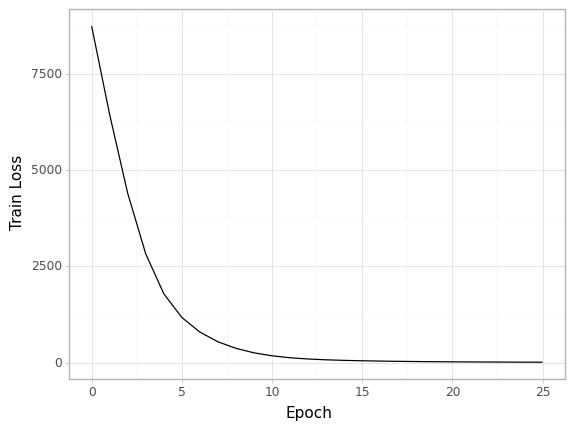

<ggplot: (8766208641277)>

In [ ]:
(
    ggplot(train_scores, aes(x='Epoch', y='Train loss'))+ geom_line(color='black') # line plot
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

In [ ]:
valid_scores = pd.DataFrame(np.hstack([(range(0, cfg.epochs+1, cfg.check_epoch), total_logs[score], [score for i in range(0, cfg.epochs+1, cfg.check_epoch)]) for score in ['Valid Recall@25', 'Valid NDCG@25', 'Valid Coverage', 'Valid Score']])).T
valid_scores.columns = ['Epoch', 'Score', 'Metric']
valid_scores['Epoch'] = valid_scores['Epoch'].astype(int)
valid_scores['Score'] = valid_scores['Score'].astype(float)

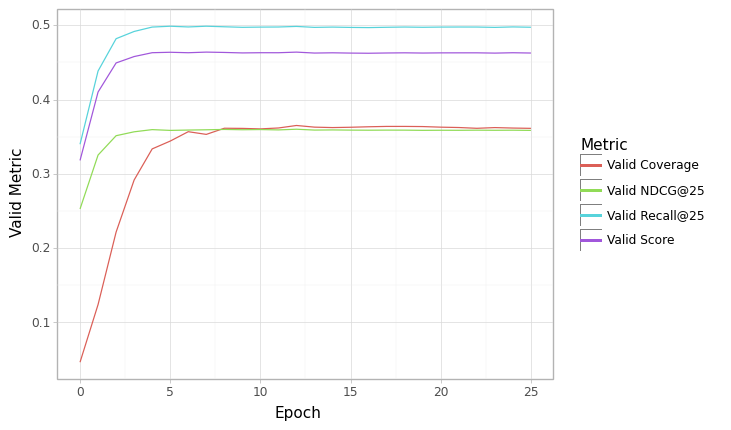

<ggplot: (8766053620445)>

In [ ]:
(
ggplot(valid_scores)  # here
    + aes("Epoch", "Score", color='Metric', group='Metric')
    + geom_line()
    + scale_y_continuous(breaks=[0.1*c for c in range(1, 10, 1)])
    + theme_light()
    + labs(x='Epoch', y='Valid Metric')
)  

## 제출 
### 모든 유저에 대해 추천 결과 생성

In [ ]:
model.load_state_dict(torch.load(os.path.join('/content/drive/MyDrive/code/saved', 'model(best_scores).pth')))

In [ ]:
submission_path = os.path.join('/content/drive/MyDrive/data', 'sample_submission.csv')
submission = pd.read_csv(submission_path)
# submission = valid_epoch(cfg, model, submission, mode='test')

In [ ]:
submission

,profile_id,predicted_list
0,3,[0]
1,5,[0]
2,7,[0]
3,12,[0]
4,16,[0]
...,...,...
8306,33022,[0]
8307,33023,[0]
8308,33026,[0]
8309,33027,[0]


### 저장

In [ ]:
submission.to_csv(os.path.join('/content', 'submission.csv'), index = False)